# Нейросетевой анализ данных из подготовленной таблицы динамики признаков
-------

**Дано:**
- имеется таблица, фиксирующая изменение всех важных признаков/фичей во времени (фичи генерировались и подбирались на предыдущем этапе);
- индексом таблицы является дата-время либо в виде TimeStamp либо в виде DateTime;
- все фичи закодированы численно либо как one-hot enc (категориальные фичи).

**Требуется:**
- разработать pipeline для эмбеддинга, кодирования окон изменения фичей с использованием AE или VAE;
- разработать функционал визуального анализа структуры кластеров кодов и соответствующих им окон;
- исследовать как архитектура сверточных слоев AE влияет на кодирование окон;
- выявить основные типы окон, которые может кодировать/распознавать/выделять АЭ в зависимости от его архитектуры.

In [ ]:
# подключаем колаб к нашему гугл-диску
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# устанавливаем рабочую директорию/каталог
import os

path = "/content/drive/My Drive/Colab Notebooks/Moneta/"
os.chdir(path)
# print(os.listdir())

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import *
import seaborn as sbn
np.set_printoptions(precision=3)

import datetime as dt
print('Last Updated On: ', dt.datetime.now().date())

import sys

""" параметры графиков """
plt.style.use('ggplot')
plt.rcParams['font.fantasy'] = 'Arial', 'Times New Roman', 'Tahoma', 'Comic Sans MS', 'Courier'

Last Updated On:  2023-01-29


# ПЛАН РАБОТ
---

1. Считываем и делаем визуальный анализ попарных зависимостей данных
1. Выбираем ширину окна. Формируем датасет и даталоадер для обучения и тестирования АЭ.
1. Строим АЭ с выделением энкодера и декодера в отдельную нейросеть
1. Обучаем АЭ
1. Кодируем энкодером окна
1. Кластеризуем окна; выбираем наилучший метод и параметры силуэтным анализом (k-means, )
1. Делаем проекцию tSNE и визуализируем кластерную структуру
1. Проводим анализ получившихся кластеров окон


## **Считываем данные**
---

Подготовленные данные 

datetime|	val_00 | val_01 | ...
--- | --- | --- | ---
01.01.2009|	29,3916 | -0.108 | ...
12.01.2009|	30,5331 | 1.1415 | ...




In [ ]:
prep_df = pd.read_csv('data/dollar_prepared.csv', header=0, sep=';', index_col=0) # 
print(prep_df.shape)
prep_df.tail(5)

(5052, 11)


,dollar,d_dollar,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,sin_month,cos_month
datetime,,,,,,,,,,,
2022-10-27,61.4012,-0.0743,0,0,0,1,0,0,0,-1.0,-1.836970e-16
2022-10-28,61.5294,0.1282,0,0,0,0,1,0,0,-1.0,-1.836970e-16
2022-10-29,61.5294,0.0000,0,0,0,0,0,1,0,-1.0,-1.836970e-16
2022-10-30,61.5294,0.0000,0,0,0,0,0,0,1,-1.0,-1.836970e-16
2022-10-31,61.6277,0.0983,1,0,0,0,0,0,0,-1.0,-1.836970e-16


In [ ]:
import datetime as dt

prep_df.index = pd.to_datetime(prep_df.index)
prep_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5052 entries, 2009-01-01 to 2022-10-31
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   dollar         5052 non-null   float64
 1   d_dollar       5052 non-null   float64
 2   day_of_week_0  5052 non-null   int64  
 3   day_of_week_1  5052 non-null   int64  
 4   day_of_week_2  5052 non-null   int64  
 5   day_of_week_3  5052 non-null   int64  
 6   day_of_week_4  5052 non-null   int64  
 7   day_of_week_5  5052 non-null   int64  
 8   day_of_week_6  5052 non-null   int64  
 9   sin_month      5052 non-null   float64
 10  cos_month      5052 non-null   float64
dtypes: float64(4), int64(7)
memory usage: 473.6 KB


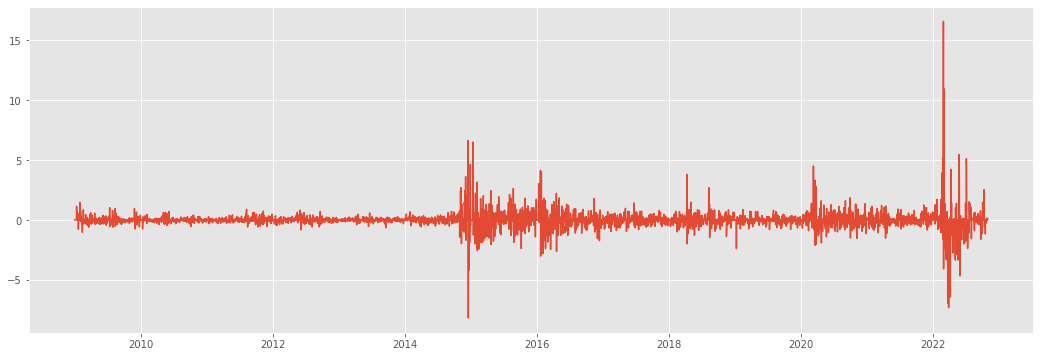

In [ ]:
plt.figure(figsize=(18,6))

plt.plot(prep_df.d_dollar.index, prep_df.d_dollar.values);

## **Визуальный анализ зависимостей признаков**
---
Выделим из загруженной таблицы поля, которые будем использовать для анализа

Также выделим временные границы для последующей работы - нет смысла использовать динамику курса до 2014 года - она была совсем другой.


In [ ]:
cond = prep_df.index > dt.datetime(year=2014, month=1, day=1)
prep_df = prep_df.loc[cond, :]
sum(cond), len(prep_df)

(3225, 3225)

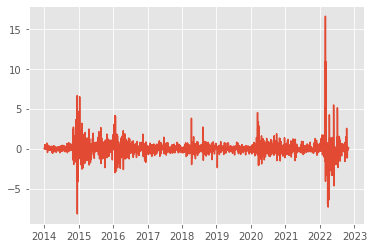

In [ ]:
plt.plot(prep_df.d_dollar.index, prep_df.d_dollar.values);

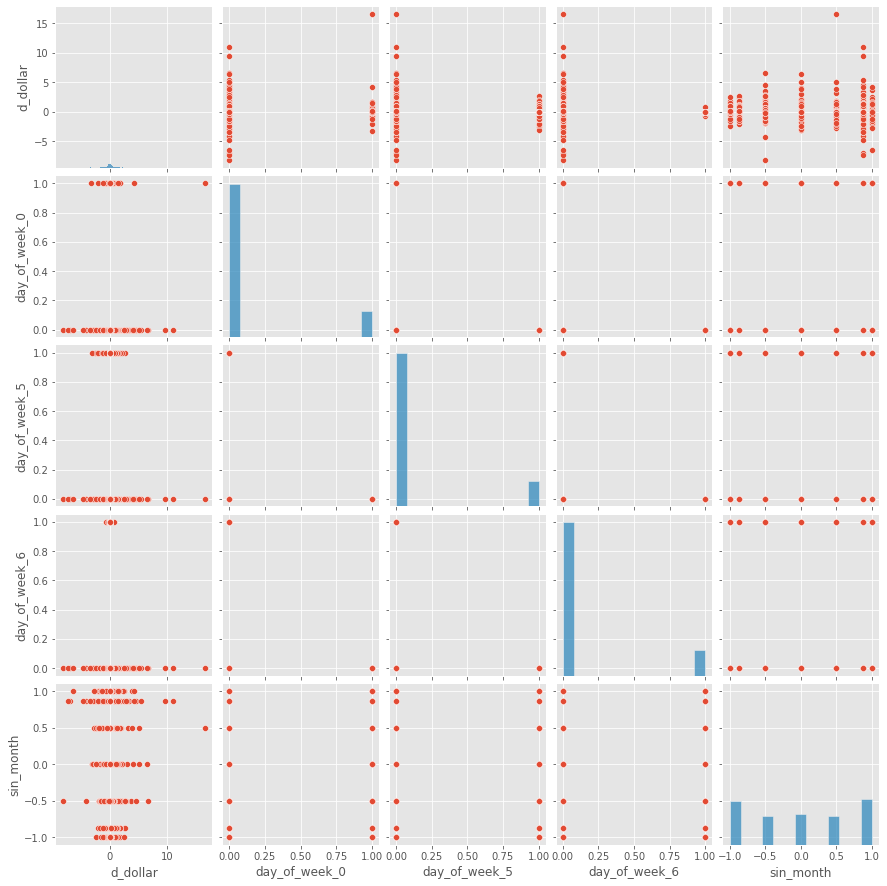

In [ ]:
features = ['d_dollar', 'day_of_week_0', 'day_of_week_5', 'day_of_week_6', 'sin_month']
sbn.pairplot(prep_df[features]);

resume:

- необходимо шкалировать чисто числовые признаки, так как они имеют разный разброс;
- есть статистическая зависимость между сезоном (месяцем) и диапазоном и средним изменений d_dollar;
- видим, что на изменение курса доллара влияет фактор выходного дня;

## **Готовим датасеты**
---
- Выбираем ширину окна win_width и шаг по окну win_step;
- формируем свой класс датасета;
- готовим datasets для обучения и для тестирования

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

if torch.cuda.is_available(): 
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='cpu')

### Выбираем признаки
---
- Выберем после результатов анализа зависимостей признаки, которые оказывают влияние на изменение основной величины (курса доллара); вектора с данными признаками будут подаваться на вход АЭ;

- также укажем конкретно какие признаки мы хотим эмбеддить/кодировать (остальные признаки будут вспомогательными для кодирования); эта информация будет использоваться для обучении АЭ при оценке лосса (будем требовать восстановления только данных целевых признаков);

- оформим все данные в виде отдельной таблицы df и тензора data; его далее мы и будем использовать как источника для формирования последовательностей векторов для обучения автоэнкодера;

In [ ]:
# уточняем признаки, с которыми далее будем работать
prep_df.columns
features = ['dollar', 'd_dollar', 'day_of_week_6', 'sin_month']
# уточняем целевые признаки, которые хотим кодировать/воспроизводить
goal_features = ['dollar', 'd_dollar']
goal_indexes = [features.index(x) for x in goal_features]
print(goal_indexes)

df = prep_df[features]
df.tail(3)

[0, 1]


,dollar,d_dollar,day_of_week_6,sin_month
datetime,,,,
2022-10-29,61.5294,0.0000,0,-1.0
2022-10-30,61.5294,0.0000,1,-1.0
2022-10-31,61.6277,0.0983,0,-1.0


### Масштабирование данных
---
- перед применение нейросети необходимо отмасштабировать данные. Это можно сделать сразу или строить pipline непосредственно при обучении/применении нейросети.

- шкалер нам может понадобиться для того, чтобы дешкалировать данные для последующего анализа.

In [ ]:
df.describe()

,dollar,d_dollar,day_of_week_6,sin_month
count,3225.000000,3225.000000,3225.000000,3.225000e+03
mean,62.975116,0.008983,0.142946,9.633866e-03
std,11.750904,0.801888,0.350072,7.072056e-01
min,32.658700,-8.182200,0.000000,-1.000000e+00
25%,58.171800,-0.134200,0.000000,-5.000000e-01
50%,64.031600,0.000000,0.000000,1.224647e-16
75%,70.945500,0.124400,0.000000,8.660254e-01
max,118.438900,16.569800,1.000000,1.000000e+00


Воспользуемся стандартным шкалером для масштабирования самого курса и его колебаний;

можно указать какие из признаков мы будем кодировать features_to_scale; в нашем случае набор признаков совпадает с целевыми признаками

In [ ]:
from sklearn.preprocessing import StandardScaler

dollar_scaler = StandardScaler()
features_to_scale = goal_features
dollar_scaler.fit(df.loc[:, features_to_scale])

df_norm = df.copy()
df_norm.loc[:, features_to_scale] = dollar_scaler.transform(df.loc[:, features_to_scale])
df_norm.describe()

,dollar,d_dollar,day_of_week_6,sin_month
count,3.225000e+03,3.225000e+03,3225.000000,3.225000e+03
mean,5.992795e-16,1.101617e-18,0.142946,9.633866e-03
std,1.000155e+00,1.000155e+00,0.350072,7.072056e-01
min,-2.580322e+00,-1.021645e+01,0.000000,-1.000000e+00
25%,-4.088248e-01,-1.785846e-01,0.000000,-5.000000e-01
50%,8.992054e-02,-1.120359e-02,0.000000,1.224647e-16
75%,6.783836e-01,1.439543e-01,0.000000,8.660254e-01
max,4.720691e+00,2.065548e+01,1.000000,1.000000e+00


In [ ]:
data = torch.tensor(torch.from_numpy(df_norm.values), dtype=torch.float32, device=device)
data.shape

<ipython-input-220-27c5b442a110>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(torch.from_numpy(df_norm.values), dtype=torch.float32, device=device)


torch.Size([3225, 4])

### Выбираем ширину окна win_width, формируем датасет последовательностей
---
данный класс можно будет использовать:
- для разделения на обучющий (до определенной даты) и тестовый (после определенной даты); 
- для оценки точности алгоритма кодирования на всей выборке;

In [ ]:
class TS_Dataset(Dataset):
    """ Формирование датасета с оконными последовательностями показателей
    data - torch-массив значений показателей с изменением времени, 
    data[idx] - набор показателей в момент времени t[idx]
    win_width - ширина окна, здесь - кол-во временных точек измерения
    transform - преобразование, которое необходимо применить к формируемой последовательности данных
    ВЫХОД:
    - для данного idx окно трансформированных показателей - torch массив размером (win_width, *data.shape)
      динамика показателей с момента t[idx] до t[idx + win_width]
    """
    def __init__(self, data:torch.Tensor, win_width:int, transform=None):
        super(TS_Dataset).__init__()
        self.win_width = win_width
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data) - self.win_width + 1

    def __getitem__(self, idx):
        idx = idx % len(self)
        data_seq = self.data[idx : idx + self.win_width]

        if self.transform:
            data_seq = self.transform(data_seq)
        return data_seq, data_seq

In [ ]:
# ширина окна
win_width = 7

all_dataset = TS_Dataset(data, win_width=win_width)
print(len(all_dataset))
all_dataset[100][0]

3219


tensor([[-2.3279,  0.0709,  0.0000,  1.0000],
        [-2.3279, -0.0112,  1.0000,  1.0000],
        [-2.3279, -0.0112,  0.0000,  1.0000],
        [-2.2969,  0.4442,  0.0000,  1.0000],
        [-2.2990, -0.0430,  0.0000,  1.0000],
        [-2.2890,  0.1357,  0.0000,  1.0000],
        [-2.3020, -0.2015,  0.0000,  1.0000]])

### Формируем выборки для обучения и тестирования и соответствующие даталоадеры
---
Применяем два способа разбиения.
- Способ 1. Выбираем дату, разделяющую всю последовательность на две части - обучающую и тестовую; это полезно для обучения прогнозированию. Для реализации данного способа можно использовать класс TS_Dataset, передав ему на вход часть тензора data.

- Способ 2. Из всех последовательностей выбираем случайно определенный % для обучающей выборки; остальные - в тестовую выборку.

Воспользуемся 2-м способом, так как у нас пока задача не прогноз. Для этого реализуем класс WindowDataset, в который можно передать не только ширину окна, но и метки времени, с которых начинать выбирать последовательности векторов. 

In [ ]:
class WindowDataset(Dataset):
    def __init__(self, data: torch.Tensor, win_width: int, starts: tuple, active_dim: int = 0, transform=None):
        self.win_width = win_width
        self.data = data
        self.transform = transform
        self.dim: int = active_dim
        self.starts = starts
        assert len(starts) <= self.data.size()[self.dim], "кол-во стартовых точек должно быть менььше кол-ва наблюдений N"
        assert 0 <= max(starts) <= self.data.size()[self.dim] - win_width, "индексы стартовых точек должны лежать в интервале [0, N-width]"

    def __len__(self):
        return len(self.starts)

    def __getitem__(self, idx) -> torch.Tensor:
        data_seq = self.data.index_select(dim=self.dim, index=torch.LongTensor([i for i in range(self.starts[idx], self.starts[idx] + self.win_width)]))
        if self.transform:
            data_seq = self.transform(data_seq)
        return data_seq, data_seq

сгенерируем метки времени для обучающей и тестовой выборки - как случайно выбранные значения из набора 0, step, 2*step, ...

In [ ]:
# шаг, с которым будем формировать данные выборки
win_step = 2

N = (len(data) - win_width) // win_step + 1
all_indexes = list(range(0, len(data)-win_width+1, win_step))
all_indexes[:3], all_indexes[-3:], N

([0, 2, 4], [3214, 3216, 3218], 1610)

In [ ]:
# Выбираем % для обучающей выборки
train_prct = 0.75

train_indexes = np.random.choice(all_indexes, size=round(train_prct * N), replace=False)
test_indexes = list(set(all_indexes).difference(set(train_indexes)))
print(f'{len(all_indexes)} = {len(train_indexes)} + {len(test_indexes)}')

1610 = 1208 + 402


In [ ]:
train_dataset = WindowDataset(data, starts=train_indexes, win_width=win_width)
test_dataset = WindowDataset(data, starts=test_indexes, win_width=win_width)
len(train_dataset), len(test_dataset)

(1208, 402)

## **Формируем даталоадеры**
---
- выбираем batch_size
- формируем даталоадеры для обучения 
- программируем обертку для даталоадера, который готовит батч
# - формируем тензор/батч для тестирования

In [ ]:
# выбираем размер пакета для обучения
batch_size = 32

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
batch_seq, _ = next(iter(test_dl))
print(batch_seq.size())
# batch_seq[0]

torch.Size([32, 7, 4])


- чтобы не было проблем с загрузкой данных на девайс, лучше использовать обвертку для даталоадеров WrappedDataLoader

- При подготовке пакета для обучения/тестирования из даталоадера 
выдается тензор вида (batch_size, seq_len, features); для nn.Conv1d необходимо менять местами индексы seq_len, feature, т.е. должен на вход поступать тензор вида (batch_size, features, seq_len); мы это сделаем также в функции preprocess

In [ ]:
def preprocess(x, y):
    x = torch.permute(x, (0, 2, 1))
    y = torch.permute(y, (0, 2, 1))
    return x.to(device), y.to(device)


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

In [ ]:
train_dl = WrappedDataLoader(train_dl, preprocess)
test_dl = WrappedDataLoader(test_dl, preprocess)

batch_seq, _ = next(iter(test_dl))
print(batch_seq.size())

torch.Size([32, 4, 7])


## **Строим АЭ с выделением энкодера в отдельную нейросеть**
---
Создадим простой сверточный автоэнкодер который выделяет важные признаки в последовательностях заданной длины заданных векторов фичей.


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

In [ ]:
# выбираем размерность скрытого слоя и размеры ядер свертки
latent_dim = 20
kernels = (5, 3)

In [ ]:
"""
для nn.Conv1d на вход должен поступать тензор вида (batch_size, features, seq_len)
seq_len должен быть нечетным
"""
class Encoder_sequence(nn.Module):
    def __init__(self, features: int, seq_len: int, latent_dim: int = 16, kernels: tuple = (5, 3)):
        super(Encoder_sequence,self).__init__()
        # channels_in,  channels_out, kernel_size, stride , padding,
        self.conv1 = nn.Conv1d(features, latent_dim * 2, kernel_size=1, stride=1, padding=0)
        self.conv2 = nn.Conv1d(latent_dim * 2, latent_dim * 4, kernel_size=kernels[0], stride=2, padding= kernels[0]//2)
        self.conv3 = nn.Conv1d(latent_dim * 4, latent_dim * 8, kernel_size=kernels[1], stride=2, padding= kernels[1]//2)
        self.conv4 = nn.Conv1d(latent_dim * 8, latent_dim, kernel_size=(seq_len+1)//4, padding=0)
        
    def forward(self,x):
        # делаем проецирование векторов из пространства feature в про-во latent_dim * 4
        out = self.conv1(x) # latent_dim*2 x seq_len // 2
        out = F.dropout(out, p=0.2)
        out = self.conv2(out) # latent_dim*4 x seq_len // 2
        out = F.elu(out)
        out = self.conv3(out) # latent_dim*8 x seq_len // 4
        out = F.elu(out)
        out = F.dropout(out, p=0.2)
        out = self.conv4(out) # latent_dim x 1

        #print(out.shape)
        return out


encoder = Encoder_sequence(features=len(features), seq_len=win_width, latent_dim=latent_dim).to(device)
batch_seq, _ = next(iter(test_dl))
print(batch_seq.size(), batch_seq[0,0,0].dtype)
encoder

torch.Size([32, 4, 7]) torch.float32


Encoder_sequence(
  (conv1): Conv1d(4, 40, kernel_size=(1,), stride=(1,))
  (conv2): Conv1d(40, 80, kernel_size=(5,), stride=(2,), padding=(2,))
  (conv3): Conv1d(80, 160, kernel_size=(3,), stride=(2,), padding=(1,))
  (conv4): Conv1d(160, 20, kernel_size=(2,), stride=(1,))
)

In [ ]:
x1 = encoder.conv1(batch_seq)
x2 = encoder.conv2(x1)
x3 = encoder.conv3(x2)
x4 = encoder.conv4(x3)
code = encoder(batch_seq)
batch_seq.size(), x1.size(), x2.size(), x3.size(), x4.size(), code.size()

(torch.Size([32, 4, 7]),
 torch.Size([32, 40, 7]),
 torch.Size([32, 80, 4]),
 torch.Size([32, 160, 2]),
 torch.Size([32, 20, 1]),
 torch.Size([32, 20, 1]))

In [ ]:
class Decoder_to_sequence(nn.Module):
    """  
    ВХОД: 
    - подается батч кодов порследовательностей - тензор размерностью (batch_size, latent_dim, 1)
    ВЫХОД:
    - бвтч последовательностей фичей - тензор размерностью (batch_size, features, seq_len)
    """
    def __init__(self,  latent_dim: int, features: int, seq_len: int, kernels: tuple = (3, 3)):
        super(Decoder_to_sequence,self).__init__()
        self.features = features
        self.seq_len = seq_len
        """ convtranspose  is different from the regular conv layer;  this link shows examples about it 
        https://towardsdatascience.com/is-the-transposed-convolution-layer-and-convolution-layer-the-same-thing-8655b751c3a1 
        """
        # channels_in ,  channels_out, kernel_size, stride , padding,
        self.transconv1 = nn.ConvTranspose1d(latent_dim, features * 16, kernel_size=3, stride=1, padding=0)
        self.transconv2 = nn.ConvTranspose1d(features * 16, features * 8, kernel_size=kernels[0], stride=2, padding=0)
        self.transconv3 = nn.ConvTranspose1d(features * 8, features,  kernel_size=kernels[1], stride=2, padding=0)
        self.conv4 = nn.Conv1d(features, features * seq_len, kernel_size=(4+kernels[0] - 1)*2 + kernels[1])
        #self.linear1 = nn.Linear()

    def forward(self, x):
        out= self.transconv1(x) # features*16 x (1-1)*1 + k0 (3)
        out = F.elu(out)
        out = F.dropout(out, p=0.2)

        out= self.transconv2(out) # features*8 x (3-1)*2 + kernels[0] (7)
        out = F.elu(out)
        out = F.dropout(out, p=0.2)

        out= self.transconv3(out)  # features x (7-1)*2 + kernels[1] (15)
        out = F.relu(out)

        out = self.conv4(out)  # features * seq_len x 1

        out = out.view(out.shape[0], self.features, self.seq_len)
        return out

decoder = Decoder_to_sequence(latent_dim=latent_dim, features=len(features), seq_len=win_width)
decoder

Decoder_to_sequence(
  (transconv1): ConvTranspose1d(20, 64, kernel_size=(3,), stride=(1,))
  (transconv2): ConvTranspose1d(64, 32, kernel_size=(3,), stride=(2,))
  (transconv3): ConvTranspose1d(32, 4, kernel_size=(3,), stride=(2,))
  (conv4): Conv1d(4, 28, kernel_size=(15,), stride=(1,))
)

In [ ]:
y1 = decoder.transconv1(code)
y2 = decoder.transconv2(y1)
y3 = decoder.transconv3(y2)
y4 = decoder.conv4(y3)
decode = decoder(code)
code.size(), y1.size(), y2.size(), y3.size(), y4.size(), decode.size()

(torch.Size([32, 20, 1]),
 torch.Size([32, 64, 3]),
 torch.Size([32, 32, 7]),
 torch.Size([32, 4, 15]),
 torch.Size([32, 28, 1]),
 torch.Size([32, 4, 7]))

In [ ]:
class CNN_ae(nn.Module):
    def __init__(self, encoder, decoder):
        super(CNN_ae, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        code = self.encoder(x)
        y = self.decoder(code)
        return y

In [ ]:
cnn_ae = CNN_ae(encoder, decoder)
cnn_ae

CNN_ae(
  (encoder): Encoder_sequence(
    (conv1): Conv1d(4, 40, kernel_size=(1,), stride=(1,))
    (conv2): Conv1d(40, 80, kernel_size=(5,), stride=(2,), padding=(2,))
    (conv3): Conv1d(80, 160, kernel_size=(3,), stride=(2,), padding=(1,))
    (conv4): Conv1d(160, 20, kernel_size=(2,), stride=(1,))
  )
  (decoder): Decoder_to_sequence(
    (transconv1): ConvTranspose1d(20, 64, kernel_size=(3,), stride=(1,))
    (transconv2): ConvTranspose1d(64, 32, kernel_size=(3,), stride=(2,))
    (transconv3): ConvTranspose1d(32, 4, kernel_size=(3,), stride=(2,))
    (conv4): Conv1d(4, 28, kernel_size=(15,), stride=(1,))
  )
)

In [ ]:
reconstucted_seq = cnn_ae(batch_seq)
reconstucted_seq.size(), batch_seq.size()

(torch.Size([32, 4, 7]), torch.Size([32, 4, 7]))

## **Обучаем АЭ**
---

In [ ]:
def loss_func(y_pred, y_true):
    return F.mse_loss(y_pred[:, goal_indexes, :], y_true[:, goal_indexes, :])

loss_func(batch_seq, reconstucted_seq)

tensor(0.9675, grad_fn=<MseLossBackward0>)

In [ ]:
# Функция обучения нейросети

def train_ae_model(model, train_loader, test_loader, epochs=5, print_step = 1, verbose=False):
    errs = []
    for epoch in range(epochs):
        for xb, yb in train_loader:
            pred = model(xb)
            # print(pred.shape, xb.shape)
            loss = loss_func(pred, xb)

            ## --- обратный проход, вычисление градиентов ---
            optimizer.zero_grad() # чтобы не накапливались градиенты
            loss.backward()

            ## --- корректировка весов ---
            optimizer.step()

        if (epoch % print_step == 0):
            with torch.no_grad():
                errs1 = []
                for xb, yb in test_loader:
                    testloss = loss_func(model(xb), yb).cpu().item()
                    errs1.append(testloss)
                meanloss = sum(errs1) / len(errs1)
                errs.append(meanloss)
            if verbose:
                print('epoch=', epoch, '; loss=', meanloss)

    return errs

err_list = []

In [ ]:
# Создадим оптимизатор
from torch.optim import Adam, RMSprop

optimizer = Adam(cnn_ae.parameters(), lr=0.0001)
# optimizer = RMSprop(cnn_ae.parameters(), lr=0.0002)

In [ ]:
errs = train_ae_model(cnn_ae, train_dl, test_dl, epochs=150, print_step=10, verbose=True)
err_list += errs

epoch= 0 ; loss= 1.1688494040415838
epoch= 10 ; loss= 0.6805137865818464
epoch= 20 ; loss= 0.5695706949784205
epoch= 30 ; loss= 0.4719712046476511
epoch= 40 ; loss= 0.41332099128227967
epoch= 50 ; loss= 0.31113565311982083
epoch= 60 ; loss= 0.2745517331820268
epoch= 70 ; loss= 0.19475601240992546
epoch= 80 ; loss= 0.16816899581597403
epoch= 90 ; loss= 0.15307103269375288
epoch= 100 ; loss= 0.13159196393994185
epoch= 110 ; loss= 0.12140061018558648
epoch= 120 ; loss= 0.1328803631835259
epoch= 130 ; loss= 0.14476320878244364
epoch= 140 ; loss= 0.10023565905598494


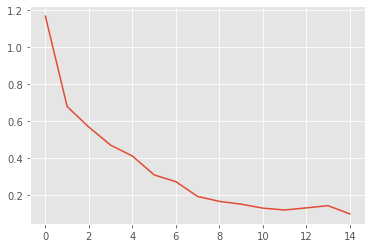

In [ ]:
plt.plot(err_list)

## **Кластеризуем окна (k-means, agglomerative, ward, DBSCAN, ...)**
---

**Кодируем энкодером последовательности**

In [ ]:
codes = []
with torch.no_grad():
    for idx in range(len(all_dataset)):
        x, _ = all_dataset[idx]
        x = x.transpose(1, 0)
        x = x.unsqueeze(0)
        # print(x.size(), end='; --> ')
        code = encoder(x).squeeze()
        # print(code.size())
        codes.append(code.detach().numpy().reshape(1, -1))

train_codes = np.concatenate(codes, axis=0)
train_codes.shape

(3219, 20)

## **Делаем проекцию tSNE и визуализируем структуру кодов**
---

In [ ]:
from sklearn.manifold import TSNE

X = train_codes
tsne = TSNE(n_components=2, perplexity=30)
X_tsne = tsne.fit_transform(X)
X_tsne.shape

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(3219, 2)

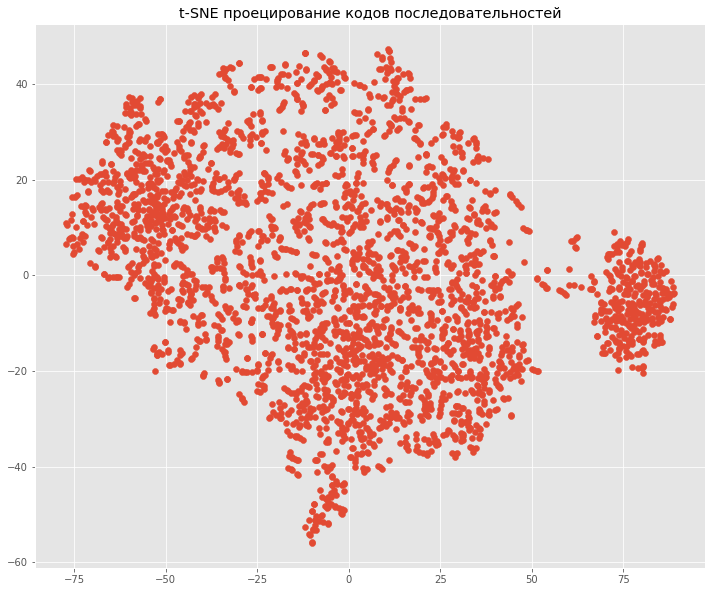

In [ ]:
plt.figure(figsize=(12,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.title('t-SNE проецирование кодов последовательностей');

## Выполним кластеризацию и проанализируем получившуюся структуру кластеров
---

### Метод kmeans++.
---
Определим оптимальное кол-во кластеров

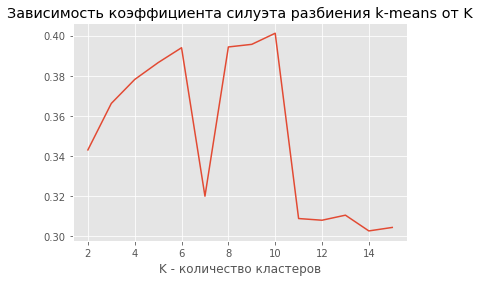

In [ ]:
# Применение k-means
from sklearn.cluster import KMeans
from sklearn import metrics

X = train_codes
k_start = 2
k_end = 15

crit2 = []
for k in range(k_start, k_end + 1):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(X)
    crit2.append(metrics.silhouette_score(X, kmeans.labels_))

plt.plot(range(k_start, k_end + 1), crit2)
plt.xlabel('K - количество кластеров')
plt.title('Зависимость коэффициента силуэта разбиения k-means от K');

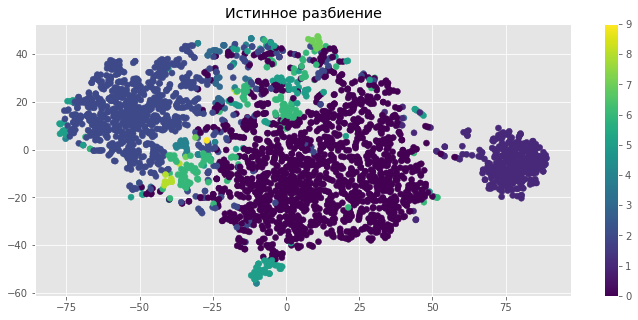

In [ ]:
kmeans = KMeans(n_clusters=10, init='k-means++', n_init=10, random_state=123)

# применяем - обучаем
kmeans.fit(X)
# метки кластеров
labels = kmeans.labels_
# визуализируем получившееся разбиение с учетом знания цифр на картинках
# и сравним с разбиением на кластеры, полученным с помощью k-means
plt.figure(figsize=(12,5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels)
plt.colorbar()
plt.title('Истинное разбиение')
plt.show()

In [ ]:
pd.Series(labels).value_counts()

0    1679
2     837
1     339
6     140
5     133
4      35
3      28
7      16
8      11
9       1
dtype: int64

Проанализируем примеры последовательностей из разных кластеров

In [ ]:
centers_code = torch.tensor(torch.from_numpy(kmeans.cluster_centers_), dtype=torch.float32, device=device)
centers_seq = decoder(centers_code.unsqueeze(dim=2))
np_centers_seq = centers_seq.detach().numpy()
centers_code.shape, centers_seq.shape, np_centers_seq.shape

<ipython-input-256-4a0dea91ac88>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  centers_code = torch.tensor(torch.from_numpy(kmeans.cluster_centers_), dtype=torch.float32, device=device)


(torch.Size([10, 20]), torch.Size([10, 4, 7]), (10, 4, 7))

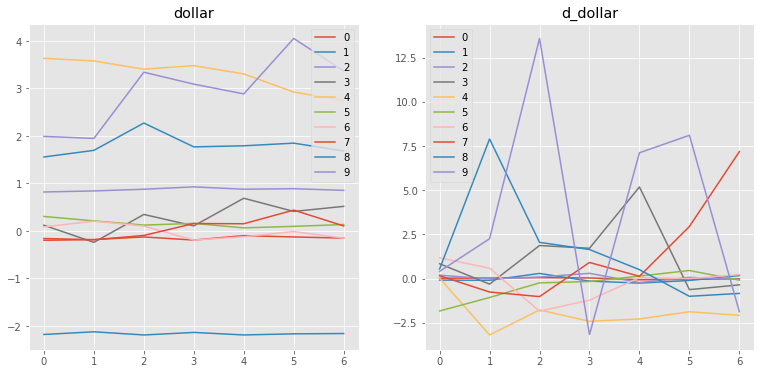

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))

# визуализируем получившиеся последовательности
for index in goal_indexes:
    ax[index].set_title(df.columns[index])
    for label in np.unique(labels):
        ax[index].plot(range(win_width), np_centers_seq[label, index, :].ravel(), label=str(label))
        ax[index].legend()

fig.show()

In [ ]:
pd.Series(labels).value_counts()

0    1679
2     837
1     339
6     140
5     133
4      35
3      28
7      16
8      11
9       1
dtype: int64

## **Сохранение обученной модели**
------

In [ ]:
model_name = 'conv_ae-seq' + str(win_width) + '-ls' + str(latent_dim) + '_k' + '-'.join([str(k) for k in kernels]) + '-2'
print(model_name)
torch.save(cnn_ae.state_dict(), path + 'models/' + model_name)

conv_ae-seq7-ls20_k5-3-2
